In [1]:
import os
import glob
import cv2
import numpy as np
import time 
import pickle 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn import svm, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle 

from skimage.feature import hog
from mpl_toolkits.mplot3d import Axes3D
import pydotplus 

from sklearn.decomposition import PCA        
# Python module from advanced lane finding
import lane

# Features Extraction and Classifier

In [2]:
def read_image(path):
    img=cv2.imread(path)
    return(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=1):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_hog_block(img_path):

    img=read_image(img_path)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    cell_per_block=1
    pix_per_cell=16
    orient=18
    block_per_row=64/pix_per_cell

    hog_features, hog_img = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=True)
    #hog_features, hog_img = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    print(min(hog_features), max(hog_features))
    #plt.plot(hog_features[5,7].ravel())
    #plt.show()

    hog_img=hog_img*255/np.max(hog_img)
    hog_img=cv2.cvtColor(hog_img.astype(np.uint8),cv2.COLOR_GRAY2BGR)


    for hog_feat_idx in [81]:
        block=(hog_feat_idx/orient)
        block_row=int((block/block_per_row))
        block_col=int(np.remainder(block,block_per_row))
        #print(block, block_row, block_col)
        top_left_corner=(block_col*pix_per_cell,block_row*pix_per_cell)
        bottom_right_corner=(top_left_corner[0]+pix_per_cell,top_left_corner[1]+pix_per_cell)
        #print(top_left_corner, bottom_right_corner)
        img=draw_boxes(img, [((top_left_corner), (bottom_right_corner))])
        hog_img=draw_boxes(hog_img, [((top_left_corner), (bottom_right_corner))])


    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

    plt.subplot(122)
    plt.imshow(hog_img, cmap='gray')
    plt.show()

0.0 0.513743821887


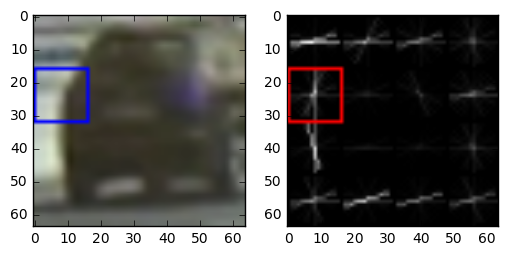

0.0019426608519 0.290354542184


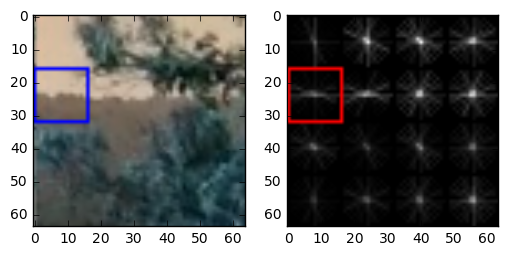

In [5]:
img_path=os.getcwd()+'/datasets/vehicles/GTI_Left/image0019.png'
draw_hog_block(img_path)

img_path=os.getcwd()+'/datasets/non-vehicles/Extras/extra9.png'
draw_hog_block(img_path)

In [3]:
class BinaryClassifier(object):
    def __init__(self, positive_fpath=None, negative_fpath=None):
           
        self.classifier=None
                
        self.y=[]
        self.X=[]
        self.X_dim_reduced=[]    # after dimension reduction
        
        self.feature_dim = None
        self.dim_reducer = None

        self.pos_fpath=positive_fpath
        self.neg_fpath=negative_fpath
        
        self.hog_params=None
        self.color_params=None

        self.x_pos=[]
        self.x_neg=[]
        
        self.train_acc=0
        self.val_acc=0
        
    def read_image(self, path):
        img=cv2.imread(path)
        img=cv2.resize(img,(64,64))
        return(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

    def normalise(self, hist):
        # normalise histogram (0,1) to (-1,1)
        return (2*hist-1)
    
    # assume input is in RGB format
    def extract_low_features(self, img):    
        hog_features=[]
        color_features=[]
        
        if self.hog_params is not None:

            pix_per_cell=self.hog_params['pixels_per_cell']
            cell_per_block=self.hog_params['cell_per_block']
            orient=self.hog_params['orient']
            
            gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            
            hog_features = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                               cells_per_block=(cell_per_block, cell_per_block), 
                               transform_sqrt=False, visualise=False, feature_vector=True)
                
        if self.color_params is not None:
            color_space = self.color_params['color_space']
            nbins = self.color_params['nbins']
            bins_range = self.color_params['bins_range']
            spatial_size = self.color_params['spatial_size']            
            
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            else: feature_image = np.copy(img)             

            # Compute the histogram of the RGB channels separately
            rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range, density=True)
            ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range, density=True)
            bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range, density=True)
            # Generating bin centers
            bin_edges = rhist[1]
            bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
            # Concatenate the histograms into a single feature vector
            hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))                
            
            spatial_features = []
            if spatial_size is not None:
                # Use cv2.resize().ravel() to create the feature vector
                spatial_features = cv2.resize(feature_image, size).ravel() 

            color_features=np.concatenate((spatial_features, hist_features))
        
        
        features=np.concatenate((hog_features, color_features))    

        # Normalise features
        features=self.normalise(features)
        
        return features
    
    def extract_features(self, hog_params, color_params):
        self.hog_params=hog_params        
        self.color_params=color_params
        
        x_pos=[]
        
        for subdir in self.pos_fpath:
            for i, fname in enumerate(glob.iglob(subdir+'/*.png')): 
                img=self.read_image(fname)
                x_pos.append(self.extract_low_features(img))

        x_neg =[]
        for subdir in self.neg_fpath:
            for i, fname in enumerate(glob.iglob(subdir+'/*.png')): 
                img=self.read_image(fname)
                x_neg.append(self.extract_low_features(img))
    

        self.X=np.vstack((x_pos,x_neg)).astype(np.float64)
        self.X_dim_reduced=self.X.copy()
        
        self.y=np.hstack((np.ones([len(x_pos)], dtype=int), 
                     np.zeros([len(x_neg)], dtype=int)))
        
        self.feature_dim=self.X.shape[1]

    def dimension_reduction(self, n_components):
        self.dim_reducer = PCA(n_components=int(n_components))
        
        self.dim_reducer.fit(self.X)
        self.X_dim_reduced=self.dim_reducer.transform(self.X)
                
    def fit(self, classifier='svm', test_size=0.0, num_samples=None):
                
        if classifier=='svm':
            self.classifier=svm.SVC(kernel='linear')
        elif classifier=='tree':
            self.classifier=tree.DecisionTreeClassifier()
        else:
            print('Invalid classifier')    
            
        if num_samples is not None:
            X_mask, y_mask = shuffle(self.X_dim_reduced, self.y, n_samples=num_samples)
        else:
            X_mask=self.X_dim_reduced
            y_mask=self.y
            
        # Shuffle and split into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_mask, y_mask, test_size=0.2)

        self.classifier.fit(X_train, y_train)

        y_pred=self.classifier.predict(X_train)
        self.train_acc=accuracy_score(y_train, y_pred)
                
        y_pred=self.classifier.predict(X_test)
        self.val_acc=accuracy_score(y_test, y_pred)
        
        print('Training accuray %.4f'%self.train_acc)        
        print('Validation accuray %.4f'%self.val_acc)
        
        return self.train_acc, self.val_acc

    # predict single image
    def predict(self, img=None, path=None):
        if path is not None:
            img=self.read_image(path)
        else:
            img=cv2.resize(img,(64,64))
            
        features=self.extract_low_features(img)
        features=features.reshape((1,-1))
        if self.dim_reducer is not None:
            features=self.dim_reducer.transform(features)
        return self.classifier.predict(features)
        

# SVM

In [6]:
car_path=['./datasets/vehicles/KITTI_extracted',
          './datasets/vehicles/GTI_MiddleClose',
          './datasets/vehicles/GTI_Right',
          './datasets/vehicles/GTI_Left',
          './datasets/vehicles/GTI_Far']

non_car_path=['./datasets/non-vehicles/Extras',
              './datasets/non-vehicles/GTI'
              './datasets/non-vehicles/syc']
    
cls=BinaryClassifier(positive_fpath=car_path, negative_fpath=non_car_path)
              
hog_params = {'pixels_per_cell': 8, 'cell_per_block': 2, 'orient':9}
color_params = {'color_space':'LUV', 'nbins':32, 'bins_range':(0,256), 'spatial_size':None}

cls.extract_features(hog_params=hog_params, color_params=color_params)
cls.fit(classifier='svm', test_size=0.3, num_samples=None)


Training accuray 0.9908
Validation accuray 0.9736


(0.99081229606731924, 0.97355769230769229)

# Try different parameters to get best classifier

In [101]:
# Hog only
hog_params = {'pixels_per_cell': 8, 'cell_per_block': 2, 'orient':9}
print(hog_params)
cls.extract_features(hog_params=hog_params, color_params=None)
cls.fit(classifier='svm', test_size=0.1, num_samples=None)

hog_params = {'pixels_per_cell': 16, 'cell_per_block': 2, 'orient':9}
print(hog_params)
cls.extract_features(hog_params=hog_params, color_params=None)
cls.fit(classifier='svm', test_size=0.1, num_samples=None)

hog_params = {'pixels_per_cell': 8, 'cell_per_block': 4, 'orient':9}
print(hog_params)
cls.extract_features(hog_params=hog_params, color_params=None)
cls.fit(classifier='svm', test_size=0.1, num_samples=None)

hog_params = {'pixels_per_cell': 8, 'cell_per_block': 2, 'orient':18}
print(hog_params)
cls.extract_features(hog_params=hog_params, color_params=None)
cls.fit(classifier='svm', test_size=0.1, num_samples=None)


{'orient': 9, 'cell_per_block': 2, 'pixels_per_cell': 8}
Training accuray 0.9827
Validation accuray 0.9602
{'orient': 9, 'cell_per_block': 2, 'pixels_per_cell': 16}
Training accuray 0.9541
Validation accuray 0.9495
{'orient': 9, 'cell_per_block': 4, 'pixels_per_cell': 8}
Training accuray 0.9693
Validation accuray 0.9557
{'orient': 18, 'cell_per_block': 2, 'pixels_per_cell': 8}
Training accuray 0.9887
Validation accuray 0.9660


(0.98866563626996395, 0.96600274725274726)

In [102]:
hog_params = {'pixels_per_cell': 4, 'cell_per_block': 2, 'orient':9}
print(hog_params)
cls.extract_features(hog_params=hog_params, color_params=None)
cls.fit(classifier='svm', test_size=0.1, num_samples=None)

{'orient': 9, 'cell_per_block': 2, 'pixels_per_cell': 4}
Training accuray 1.0000
Validation accuray 0.9420


(1.0, 0.9419642857142857)

In [103]:
# Color only
color_params = {'color_space':'LUV', 'nbins':32, 'bins_range':(0,256), 'spatial_size':None}
print(color_params)
cls.extract_features(hog_params=None, color_params=color_params)
cls.fit(classifier='svm', test_size=0.1, num_samples=None)

color_params = {'color_space':'LUV', 'nbins':16, 'bins_range':(0,256), 'spatial_size':None}
print(color_params)
cls.extract_features(hog_params=None, color_params=color_params)
cls.fit(classifier='svm', test_size=0.1, num_samples=None)

color_params = {'color_space':'LUV', 'nbins':8, 'bins_range':(0,256), 'spatial_size':None}
print(color_params)
cls.extract_features(hog_params=None, color_params=color_params)
cls.fit(classifier='svm', test_size=0.1, num_samples=None)


{'bins_range': (0, 256), 'nbins': 32, 'color_space': 'LUV', 'spatial_size': None}
Training accuray 0.9333
Validation accuray 0.9375
{'bins_range': (0, 256), 'nbins': 16, 'color_space': 'LUV', 'spatial_size': None}
Training accuray 0.8476
Validation accuray 0.8465
{'bins_range': (0, 256), 'nbins': 8, 'color_space': 'LUV', 'spatial_size': None}
Training accuray 0.7842
Validation accuray 0.7926


(0.78421775716984377, 0.79258241758241754)

## Best Model

In [ ]:
hog_params = {'pixels_per_cell': 8, 'cell_per_block': 2, 'orient':18}
color_params = {'color_space':'LUV', 'nbins':32, 'bins_range':(0,256), 'spatial_size':None}
cls.extract_features(hog_params=hog_params, color_params=color_params)
cls.fit(classifier='svm', test_size=0.2, num_samples=None)

Training accuray 0.9947
Validation accuray 0.9753


(0.99467628370255878, 0.97527472527472525)

In [ ]:
cls.dimension_reduction(cls.feature_dim/2)
cls.fit(classifier='svm', test_size=0.2, num_samples=None)  

# Save Model

In [88]:
if cls.val_acc>0.97:
    with open('car_classifier.pkl', 'wb') as fid:
        pickle.dump(cls, fid)

# Dimension Reduction Using PCA

In [15]:
img_path='./datasets/non-vehicles/GTI/image1.png'
#img_path='./datasets/vehicles/KITTI_extracted/1.png'
print(cls.predict(path=img_path))

[0]


# Decision Tree
We use decision tree to examine which HOG feature is important. We will then use this information to explore pruning i.e. removing features that are not important, which can show significant reductino in the feature and hence improved computational time.

In [53]:
tree_cls=BinaryClassifier(positive_fpath=car_path, negative_fpath=non_car_path)
              
hog_params = {'pixels_per_cell': 8, 'cell_per_block': 2, 'orient':9}
#color_params = {'color_space':'LUV', 'nbins':32, 'bins_range':(0,256), 'spatial_size':None}

tree_cls.extract_features(hog_params=hog_params, color_params=None)
tree_cls.fit(classifier='tree', test_size=0.1, num_samples=None)

tree.export_graphviz(clf, out_file='tree.dot')

Training accuray 1.0000
Validation accuray 0.8698


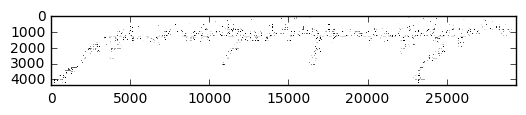

In [7]:
# Use command line to plot tree in image
#dot -Tpng tree.dot -o tree.png

plt.imshow(mpimg.imread('tree.png'))
plt.show()

#### Illutrate the HoG block that matters the most to making decision on a vehicle and a non-vehicle image. 

## Decision Tree Pruning
Now try to fit decision tree using only 1 bin of HOG from previous result. The accuracy is the same as previously!

# Sliding Windows

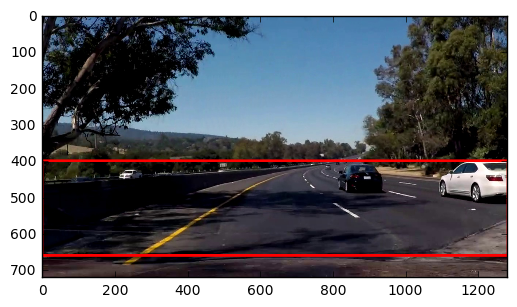

"\ni=3825\nfor box in car_detector.sliding_window_row(img,(64,64),(8,8),(400,480), dbg=True):\n    frame=img[box[0][1]:box[1][1],box[0][0]:box[1][0],:]\n    fpathname='./datasets/non-vehicles/syc/img'+str(i)+'.png'\n    cv2.imwrite(fpathname,frame)\n    print(fpathname)\n    i=i+1\n"

In [70]:
# Load test image
#%matplotlib notebook
img=read_image('test1040.jpg')
y_search_min=400
y_search_max=660
img2=draw_boxes(img, [((0,y_search_min), (1279,y_search_max))],thick=6)
plt.imshow(img2)
plt.show()

"""
i=3825
for box in car_detector.sliding_window_row(img,(64,64),(8,8),(400,480), dbg=True):
    frame=img[box[0][1]:box[1][1],box[0][0]:box[1][0],:]
    fpathname='./datasets/non-vehicles/syc/img'+str(i)+'.png'
    cv2.imwrite(fpathname,frame)
    print(fpathname)
    i=i+1
"""

In [7]:
class CarDetector(object):
    def __init__(self, clf):
        self.detected_cars=[]
        self.observed_boxes=[]
        self.multiscale_windows=[[(80,80),(20,20),(400,560)],
                                 [(100,100),(20,20),(400,550)],
                                 [(160,160),(80,80),(450,660)]]
        self.classifier=clf
        self.lane_finder=lane.Finder()
        
    def sliding_window_row(self, img, window_size, step_size, y_loc, dbg=False):

        for y_top in range(y_loc[0], y_loc[1],step_size[1]):
            y_bottom=y_top+window_size[1]
            if y_bottom>y_loc[1]:
                break
            for x_left in range(0, img.shape[1],step_size[0]):
            #for x_left in range(720, 800,step_size[0]):
                x_right=x_left+window_size[0]
                if x_right>img.shape[1]:
                    break
                window=img[y_top:y_bottom,x_left:x_right,:]
                detected=self.classifier.predict(window)
                if dbg==True or detected:
                    yield(((x_left,y_top),(x_right,y_bottom)))
                else:
                    yield None        

    def detect_car(self, img):
        boxes=[]
        for window_step in self.multiscale_windows:
            for box in self.sliding_window_row(img, window_step[0] ,window_step[1], window_step[2], dbg=False):
                if box is not None:
                    boxes.append(box)
        return boxes
    
    def calc_overlap(self, box1, box2):
       
        x1 = box1[0][0]
        y1 = box1[0][1]
        x2 = box1[1][0]
        y2 = box1[1][1]
        
        x3 = box2[0][0]
        y3 = box2[0][1]
        x4 = box2[1][0]
        y4 = box2[1][1]
        
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = max(x1, x3)
        yy1 = max(y1, y3)
        
        xx2 = min(x2, x4)
        yy2 = min(y2, y4)

        # compute the width and height of the bounding box
        w = max(0, xx2 - xx1 + 1)
        h = max(0, yy2 - yy1 + 1)

        # compute the ratio of overlap between the computed
        # bounding box and the bounding box in the area list

        area1 = (x2 - x1 + 1) * (y2 - y1 + 1)
        area2 = (x4 - x3 + 1) * (y4 - y3 + 1)
        overlap = float(w * h) / min(area1, area2)
        return overlap

                
    def clean_up_boxes(self, boxes, overlapThresh):
        if len(boxes)==0:
            return []

        # initialise clean boxes
        cleaned_boxes=[]

        # grab coordinates of the bounding boxes

        x1 = boxes[:,0,0]
        y1 = boxes[:,0,1]
        x2 = boxes[:,1,0]
        y2 = boxes[:,1,1]

        # compute the area of the bounding boxes and sort the bounding
        # boxes by the bottom-right y-coordinate of the bounding box
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)    
        count=len(idxs)
        while len(idxs) > 0 and count>0:
            count=count-1
            last = len(idxs)-1        
            i=idxs[last]
            suppress=[]
            overlap_flag=False
            for pos in range(0, last):

                # grab the current index
                j = idxs[pos]

                # find the largest (x, y) coordinates for the start of
                # the bounding box and the smallest (x, y) coordinates
                # for the end of the bounding box
                xx1 = max(x1[i], x1[j])
                yy1 = max(y1[i], y1[j])
                xx2 = min(x2[i], x2[j])
                yy2 = min(y2[i], y2[j])

                # compute the width and height of the bounding box
                w = max(0, xx2 - xx1 + 1)
                h = max(0, yy2 - yy1 + 1)

                # compute the ratio of overlap between the computed
                # bounding box and the bounding box in the area list
                overlap = float(w * h) / area[j]

                # if there is sufficient overlap, merge them
                # and mark the current box to be deleted
                if overlap > overlapThresh:
                    x1[i]=min(x1[i],x1[j])
                    y1[i]=min(y1[i],y1[j])
                    x2[i]=max(x2[i],x2[j])
                    y2[i]=max(y2[i],y2[j])
                    suppress.append(pos)
                    overlap_flag=True
                else:
                    overlap_flag=False

            if overlap_flag==False:
                cleaned_boxes.append(((x1[i],y1[i]),(x2[i],y2[i])))
                suppress.append(last)

            idxs = np.delete(idxs, suppress)
            #print('last',last, 'i', i)
            #print('suppress',suppress,'idxs', idxs)
            # delete all indexes from the index list that are in the
            # suppression list


        #for i in idxs:
        #    cleaned_boxes.append(((x1[i],y1[i]),(x2[i],y2[i])))

        return cleaned_boxes


    def pipeline(self, image, aug_lane=True, dbg=False):
        boxes=self.detect_car(image)       
        clean_boxes=self.clean_up_boxes(np.array(boxes), 0.3)

        prev_detected_car=self.detected_cars+self.observed_boxes
        self.detected_cars=[]
        self.observed_boxes=[]
        for new_box in clean_boxes:
            found=False
            for detected_car in prev_detected_car:
                if self.calc_overlap(new_box, detected_car)>0.5:
                    found=True
                    break
            if found==True:
                self.detected_cars.append(new_box)
            else:
                self.observed_boxes.append(new_box)
        
        if aug_lane==True:
            image=self.lane_finder.process_image(image)
            
        aug_img=draw_boxes(image, self.detected_cars,thick=6)

        if dbg==True:
            unclean_aug_img=draw_boxes(image, boxes,thick=6)
            plt.figure(figsize=(12,12))
            plt.imshow(np.hstack((unclean_aug_img,aug_img)))
            plt.show()
            print(self.detected_cars)
            
        return(aug_img)
    
car_detector=CarDetector(cls)

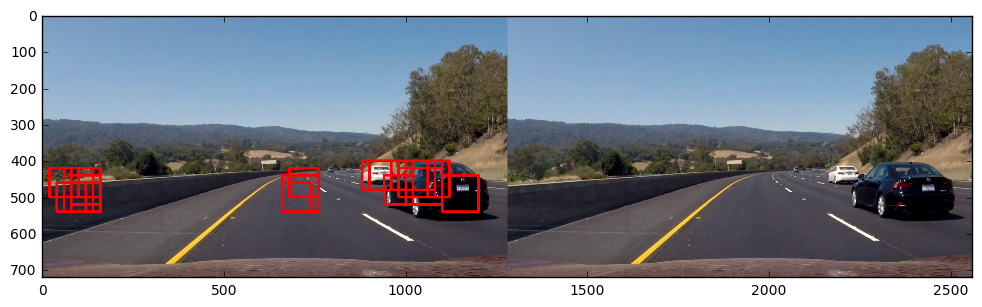

[]


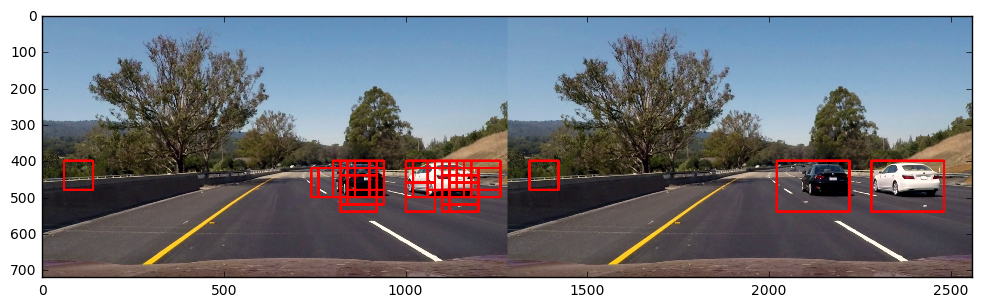

[((1000, 400), (1200, 540)), ((740, 400), (940, 540)), ((60, 400), (140, 480))]


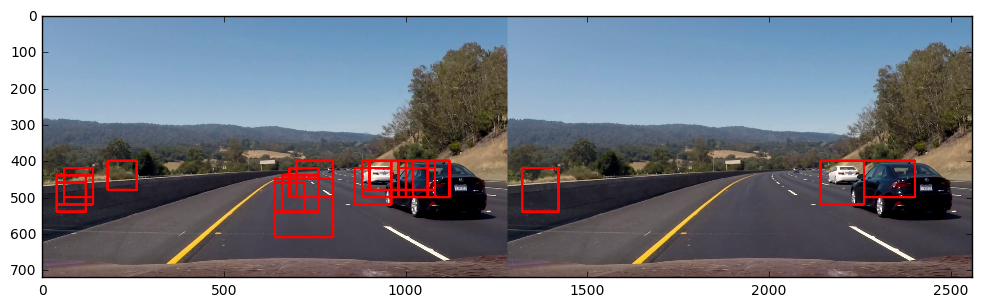

[((40, 420), (140, 540)), ((860, 400), (980, 520)), ((980, 400), (1120, 500))]


In [8]:
img=read_image('test758.jpg')
_=car_detector.pipeline(image=img, aug_lane=False, dbg=True)
img=read_image('test759.jpg')
_=car_detector.pipeline(image=img, aug_lane=False, dbg=True)
img=read_image('test760.jpg')
_=car_detector.pipeline(image=img, aug_lane=False, dbg=True)

# Debugging

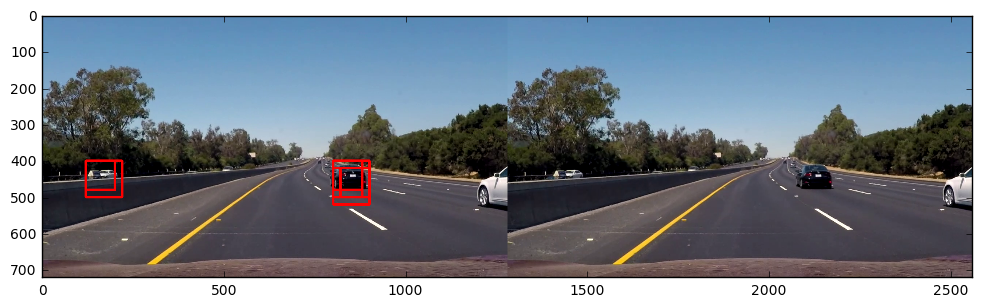

[]


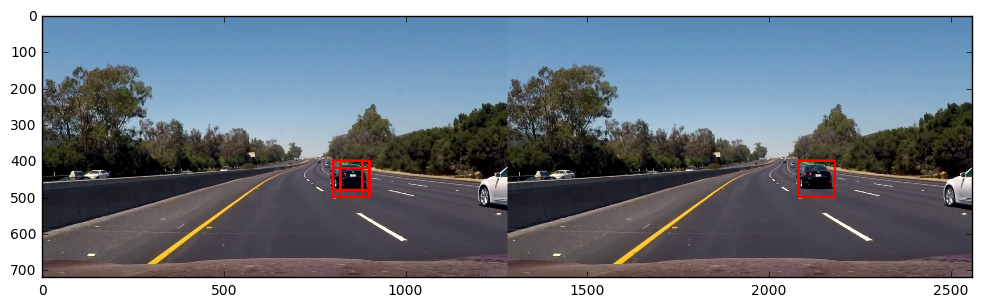

[((800, 400), (900, 500))]


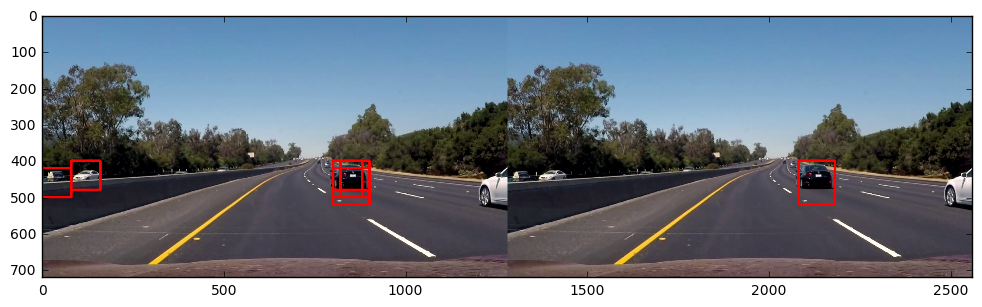

[((800, 400), (900, 520))]


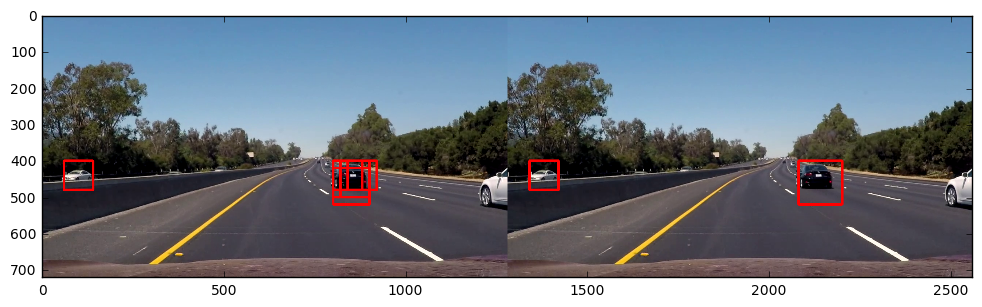

[((800, 400), (920, 520)), ((60, 400), (140, 480))]


In [96]:
cap = cv2.VideoCapture("project_video.mp4") #video_name is the video being called
for fn in range(1179,1183): # enter the range of frames to view
    cap.set(1,fn); # Where frame_no is the frame you want
    ret, frame = cap.read() # Read the frame
    cv2.imwrite('test1179.jpg',frame)
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    aug_frame=car_detector.pipeline(frame, dbg=True)
    
    aug_frame=cv2.cvtColor(aug_frame,cv2.COLOR_RGB2BGR)
    cv2.putText(aug_frame, "Frame "+str(fn), (400, 450),
           cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)    
    
    cv2.imshow('window_name', aug_frame) # show frame on window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    


In [27]:
cv2.destroyAllWindows()  

# Video

In [114]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip_output = clip1.fl_image(car_detector.pipeline) #NOTE: this function expects color images!!
%time clip_output.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [51:43<00:02,  2.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

Wall time: 51min 43s
